# MLP GenCode 
MLP_GenCode_109 with one change.  
Now use NEURONS=32 instead of 128.  
accuracy: 96.71%, AUC: 99.95%

In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-07-19 22:30:23 UTC


In [2]:
PC_TRAINS=8000
NC_TRAINS=8000
PC_TESTS=8000
NC_TESTS=8000   # Wen et al 2019 used 8000 and 2000 of each class
PC_LENS=(200,99000)
NC_LENS=(200,99000)    # Wen et al 2019 used 250-3500 for lncRNA only
MAX_K = 3
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=32
DROP_RATE=0.25
EPOCHS=100 # 25
SPLITS=5
FOLDS=5   # make this 5 for serious testing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint


In [4]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open('GenCodeTools.py', 'w') as f:
        f.write(r.text)  
    from GenCodeTools import GenCodeLoader
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.GenCodeTools import GenCodeLoader
        from SimTools.KmerTools import KmerTools
MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

On Google CoLab, mount cloud-local file, get our code from GitHub.
Mounted at /content/drive/


## Data Load
Restrict mRNA to those transcripts with a recognized ORF.

In [5]:
PC_FILENAME='gencode.v26.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v26.lncRNA_transcripts.fa.gz'
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME

In [6]:
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_utr(False)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))
show_time()

PC seqs loaded: 106143
NC seqs loaded: 48752
2021-07-19 22:30:54 UTC


## Data Prep

In [7]:
def dataframe_length_filter(df,low_high):
    (low,high)=low_high
    # The pandas query language is strange, 
    # but this is MUCH faster than loop & drop.
    return df[ (df['seqlen']>=low) & (df['seqlen']<=high) ]
def dataframe_shuffle(df):
    # The ignore_index option is new in Pandas 1.3. 
    # The default (False) replicates the old behavior: shuffle the index too.
    # The new option seems more logical th
    # After shuffling, df.iloc[0] has index == 0.
    # return df.sample(frac=1,ignore_index=True)
    return df.sample(frac=1)  # Use this till CoLab upgrades Pandas
def dataframe_extract_sequence(df):
    return df['sequence'].tolist()

pc_all = dataframe_extract_sequence(
    #dataframe_shuffle(
    dataframe_length_filter(pcdf,PC_LENS))#)
nc_all = dataframe_extract_sequence(
    #dataframe_shuffle(
    dataframe_length_filter(ncdf,NC_LENS))#)

#pc_all=['CAAAA','CCCCC','AAAAA','AAACC','CCCAA','CAAAA','CCCCC','AACAA','AAACC','CCCAA']
#nc_all=['GGGGG','TTTTT','GGGTT','GGGTG','TTGTG','GGGGG','TTTTT','GGTTT','GGGTG','TTGTG']

show_time()
print("PC seqs pass filter:",len(pc_all))
print("NC seqs pass filter:",len(nc_all))
# Garbage collection to reduce RAM footprint
pcdf=None
ncdf=None

2021-07-19 22:30:54 UTC
PC seqs pass filter: 105685
NC seqs pass filter: 48469


In [8]:
# Any portion of a shuffled list is a random selection
pc_train=pc_all[:PC_TRAINS] 
nc_train=nc_all[:NC_TRAINS]
pc_test=pc_all[PC_TRAINS:PC_TRAINS+PC_TESTS] 
nc_test=nc_all[NC_TRAINS:NC_TRAINS+PC_TESTS]
print("PC train, NC train:",len(pc_train),len(nc_train))
print("PC test, NC test:",len(pc_test),len(nc_test))
# Garbage collection
pc_all=None
nc_all=None

PC train, NC train: 8000 8000
PC test, NC test: 8000 8000


In [9]:
def prepare_x_and_y(seqs1,seqs0):
    len1=len(seqs1)
    len0=len(seqs0)
    total=len1+len0
    L1=np.ones(len1,dtype=np.int8)
    L0=np.zeros(len0,dtype=np.int8)
    S1 = np.asarray(seqs1)
    S0 = np.asarray(seqs0)
    all_labels = np.concatenate((L1,L0))
    all_seqs = np.concatenate((S1,S0))  
    return all_seqs,all_labels  # use this to test unshuffled
    # bug in next line?
    X,y = shuffle(all_seqs,all_labels) # sklearn.utils.shuffle 
    #Doesn't fix it
    #X = shuffle(all_seqs,random_state=3) # sklearn.utils.shuffle 
    #y = shuffle(all_labels,random_state=3) # sklearn.utils.shuffle 
    return X,y
Xseq,y=prepare_x_and_y(pc_train,nc_train)
print(Xseq[:3])
print(y[:3])
# Tests:
show_time()

['CCCAGATCTCTTCAGTTTTTATGCCTCATTCTGTGAAAATTGCTGTAGTCTCTTCCAGTTATGAAGAAGGTAACTGCAGAGGCTATTTCCTGGAATGAATCAACGAGTGAAACGAATAACTCTATGGTGACTGAATTCATTTTTCTGGGTCTCTCTGATTCTCAGGAACTCCAGACCTTCCTATTTATGTTGTTTTTTGTATTCTATGGAGGAATCGTGTTTGGAAACCTTCTTATTGTCATAACAGTGGTATCTGACTCCCACCTTCACTCTCCCATGTACTTCCTGCTAGCCAACCTCTCACTCATTGATCTGTCTCTGTCTTCAGTCACAGCCCCCAAGATGATTACTGACTTTTTCAGCCAGCGCAAAGTCATCTCTTTCAAGGGCTGCCTTGTTCAGATATTTCTCCTTCACTTCTTTGGTGGGAGTGAGATGGTGATCCTCATAGCCATGGGCTTTGACAGATATATAGCAATATGCAAGCCCCTACACTACACTACAATTATGTGTGGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCTTTCTCCATTCGGTGAGCCAGTTGGCGTTTGCCGTGCACTTACTCTTCTGTGGTCCCAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAACTTGCCTGTACAGATACCTACAGGCTAGATATTATGGTCATTGCTAACAGTGGTGTGCTCACTGTGTGTTCTTTTGTTCTTCTAATCATCTCATACACTATCATCCTAATGACCATCCAGCATCGCCCTTTAGATAAGTCGTCCAAAGCTCTGTCCACTTTGACTGCTCACATTACAGTAGTTCTTTTGTTCTTTGGACCATGTGTCTTTATTTATGCCTGGCCATTCCCCATCAAGTCATTAGATAAATTCCTTGCTGTATTTTATTCTGTGATCACCCCTCTCTTGAACCCAATTATATACACACTGAGGAACAAAGACATGAAGACGGCAATAAG

In [10]:
def seqs_to_kmer_freqs(seqs,max_K):
    tool = KmerTools()  # from SimTools
    empty = tool.make_dict_upto_K(max_K)
    collection = []
    for seq in seqs:
        counts = empty
        # Last param should be True when using Harvester.
        counts = tool.update_count_one_K(counts,max_K,seq,True)
        # Given counts for K=3, Harvester fills in counts for K=1,2.
        counts = tool.harvest_counts_from_K(counts,max_K)
        fdict = tool.count_to_frequency(counts,max_K)
        freqs = list(fdict.values())
        collection.append(freqs)
    return np.asarray(collection)
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
show_time()

2021-07-19 22:31:10 UTC


## Neural network

In [11]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))  # relu doesn't work as well
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',    # adadelta doesn't work as well
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2720      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,809
Trainable params: 3,809
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS,shuffle=True)
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/100
400/400 [==============================] - 16s 3ms/step - loss: 0.7170 - accuracy: 0.4924 - val_loss: 0.6912 - val_accuracy: 0.4953
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/100
400/400 [==============================] - 1s 2ms/step - loss: 0.7006 - accuracy: 0.5068 - val_loss: 0.6909 - val_accuracy: 0.4953
Epoch 3/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6914 - accuracy: 0.5272 - val_loss: 0.6806 - val_accuracy: 0.8072
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 4/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6845 - accuracy: 0.5581 - val_loss: 0.6629 - val_accuracy: 0.9256
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 5/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6645 - accuracy: 0.6041 - val_loss: 0.6152 - val_accuracy: 0.9284
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 6/100
400/400 [============

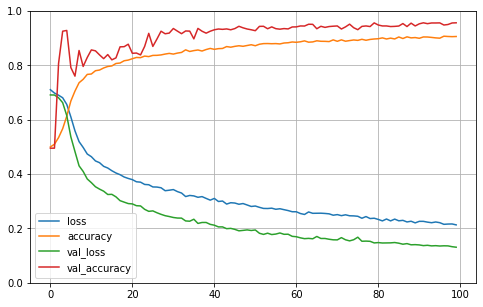

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/100
400/400 [==============================] - 2s 3ms/step - loss: 0.7169 - accuracy: 0.4981 - val_loss: 0.6904 - val_accuracy: 0.4972
Epoch 2/100
400/400 [==============================] - 1s 2ms/step - loss: 0.7000 - accuracy: 0.5075 - val_loss: 0.6902 - val_accuracy: 0.4975
Epoch 3/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6924 - accuracy: 0.5263 - val_loss: 0.6803 - val_accuracy: 0.8922
Epoch 4/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6832 - accuracy: 0.5654 - val_loss: 0.6656 - val_accuracy: 0.4972
Epoch 5/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6683 - accuracy: 0.5923 - val_loss: 0.6208 - val_accuracy: 0.7713
Epoch 6/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6284 - accuracy: 0.6571 - val_loss: 0.5542 - val_accuracy: 0.9091
Epoch 7/100
400/400 [==============================] - 1s 2ms/step - loss: 0.5822 - accuracy: 0.688

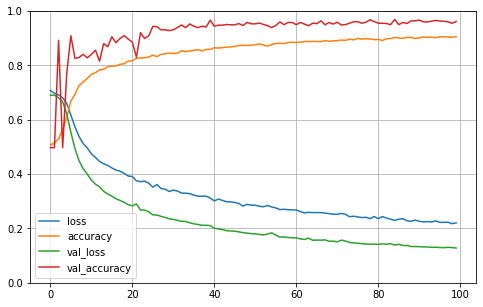

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/100
400/400 [==============================] - 2s 3ms/step - loss: 0.7141 - accuracy: 0.5076 - val_loss: 0.6902 - val_accuracy: 0.5031
Epoch 2/100
400/400 [==============================] - 1s 2ms/step - loss: 0.7007 - accuracy: 0.5108 - val_loss: 0.6866 - val_accuracy: 0.6644
Epoch 3/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6910 - accuracy: 0.5369 - val_loss: 0.6804 - val_accuracy: 0.5031
Epoch 4/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6842 - accuracy: 0.5538 - val_loss: 0.6606 - val_accuracy: 0.7203
Epoch 5/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6640 - accuracy: 0.6019 - val_loss: 0.6075 - val_accuracy: 0.8247
Epoch 6/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6210 - accuracy: 0.6538 - val_loss: 0.5329 - val_accuracy: 0.7966
Epoch 7/100
400/400 [==============================] - 1s 2ms/step - loss: 0.5720 - accuracy: 0.698

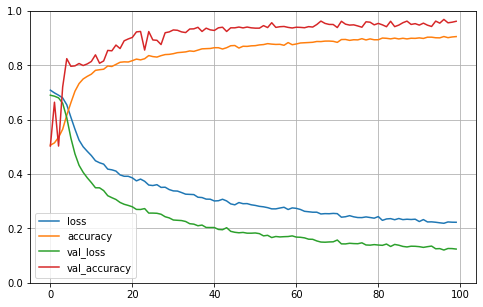

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/100
400/400 [==============================] - 2s 3ms/step - loss: 0.7178 - accuracy: 0.5014 - val_loss: 0.6901 - val_accuracy: 0.4872
Epoch 2/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6980 - accuracy: 0.5072 - val_loss: 0.6865 - val_accuracy: 0.4872
Epoch 3/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6915 - accuracy: 0.5279 - val_loss: 0.6772 - val_accuracy: 0.9231
Epoch 4/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6803 - accuracy: 0.5637 - val_loss: 0.6527 - val_accuracy: 0.7750
Epoch 5/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6602 - accuracy: 0.6064 - val_loss: 0.5978 - val_accuracy: 0.8075
Epoch 6/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6107 - accuracy: 0.6606 - val_loss: 0.5272 - val_accuracy: 0.7781
Epoch 7/100
400/400 [==============================] - 1s 2ms/step - loss: 0.5597 - accuracy: 0.709

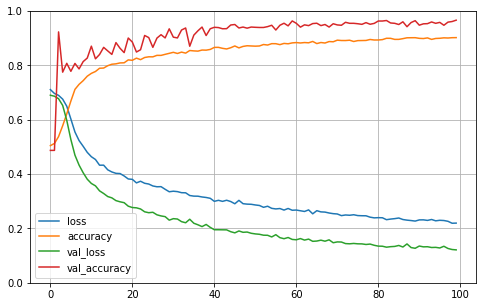

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/100
400/400 [==============================] - 2s 3ms/step - loss: 0.7100 - accuracy: 0.5025 - val_loss: 0.6906 - val_accuracy: 0.5075
Epoch 2/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6981 - accuracy: 0.5143 - val_loss: 0.6881 - val_accuracy: 0.5125
Epoch 3/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6938 - accuracy: 0.5225 - val_loss: 0.6810 - val_accuracy: 0.6553
Epoch 4/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6836 - accuracy: 0.5656 - val_loss: 0.6645 - val_accuracy: 0.6034
Epoch 5/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6603 - accuracy: 0.6158 - val_loss: 0.6090 - val_accuracy: 0.8103
Epoch 6/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6238 - accuracy: 0.6500 - val_loss: 0.5417 - val_accuracy: 0.8056
Epoch 7/100
400/400 [==============================] - 1s 2ms/step - loss: 0.5724 - accuracy: 0.701

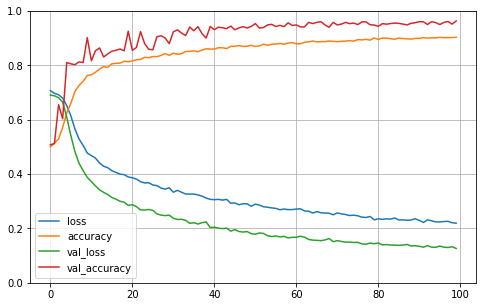

In [13]:
do_cross_validation(Xfrq,y)

In [14]:
from keras.models import load_model
print(pc_train[0])
Xseq,y=prepare_x_and_y(pc_train,nc_train)
print(Xseq[0])
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
print(Xfrq[0])
X=Xfrq
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))

CCCAGATCTCTTCAGTTTTTATGCCTCATTCTGTGAAAATTGCTGTAGTCTCTTCCAGTTATGAAGAAGGTAACTGCAGAGGCTATTTCCTGGAATGAATCAACGAGTGAAACGAATAACTCTATGGTGACTGAATTCATTTTTCTGGGTCTCTCTGATTCTCAGGAACTCCAGACCTTCCTATTTATGTTGTTTTTTGTATTCTATGGAGGAATCGTGTTTGGAAACCTTCTTATTGTCATAACAGTGGTATCTGACTCCCACCTTCACTCTCCCATGTACTTCCTGCTAGCCAACCTCTCACTCATTGATCTGTCTCTGTCTTCAGTCACAGCCCCCAAGATGATTACTGACTTTTTCAGCCAGCGCAAAGTCATCTCTTTCAAGGGCTGCCTTGTTCAGATATTTCTCCTTCACTTCTTTGGTGGGAGTGAGATGGTGATCCTCATAGCCATGGGCTTTGACAGATATATAGCAATATGCAAGCCCCTACACTACACTACAATTATGTGTGGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCTTTCTCCATTCGGTGAGCCAGTTGGCGTTTGCCGTGCACTTACTCTTCTGTGGTCCCAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAACTTGCCTGTACAGATACCTACAGGCTAGATATTATGGTCATTGCTAACAGTGGTGTGCTCACTGTGTGTTCTTTTGTTCTTCTAATCATCTCATACACTATCATCCTAATGACCATCCAGCATCGCCCTTTAGATAAGTCGTCCAAAGCTCTGTCCACTTTGACTGCTCACATTACAGTAGTTCTTTTGTTCTTTGGACCATGTGTCTTTATTTATGCCTGGCCATTCCCCATCAAGTCATTAGATAAATTCCTTGCTGTATTTTATTCTGTGATCACCCCTCTCTTGAACCCAATTATATACACACTGAGGAACAAAGACATGAAGACGGCAATAAGAC

predictions.shape (16000, 1)
first prediction [5.6787233e-08]


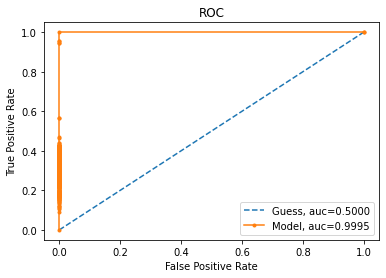

AUC: 99.95%


In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
print("predictions.shape",bm_probs.shape)
print("first prediction",bm_probs[0])
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))
